# E2E test notebook cell for PFM MVP API

(NOTE)

Make sure to run the backend (uvicorn app.main:app --reload --port 8000) before running the tests

## Setup (safe to re-run)

In [1]:
# Ping & setup
import os, json, time, math, random
from pathlib import Path
from pprint import pprint
from datetime import date, datetime, timedelta
import requests

random.seed(7)
os.environ["PYTHONHASHSEED"] = "0"

BASE      = os.getenv("BASE", "http://localhost:8000").rstrip("/")
EMAIL     = os.getenv("EMAIL", "demo@example.com")
PASSWORD  = os.getenv("PASSWORD", "demo123")

APPLY_SIM_WEIGHTS   = False   # set True to test /fed/sim/apply
ROLLBACK_AT_THE_END = True

# Seeding knobs
SEED_LOGINS_N       = 6
SEED_TX_N           = 25
SEED_TX_START_DAYS  = 18

# Fed sim knobs
SIM_BODY  = {"clients": 8, "rounds": 10, "local_epochs": 2, "lr": 0.2,
             "init_from_live": True, "prox_mu": 0.0, "dp": False}
SIM_BODY_PROX = {**SIM_BODY, "rounds": 6, "prox_mu": 0.1}
SIM_BODY_DP   = {**SIM_BODY, "dp": True, "dp_clip": 0.5, "dp_sigma": 1.0}

EVAL_BODY = {"hours": 168, "limit": 1000, "step_up": 60, "hard_deny": 90, "max_seconds": 5}

ART = Path("./artifacts"); ART.mkdir(parents=True, exist_ok=True)

s = requests.Session()
HEADERS = {"Content-Type": "application/json"}

def section(t): 
    print("\n" + "="*len(t)); print(t); print("="*len(t))

def api(method, path, *, json_body=None, params=None, ok=(200,)):
    url = f"{BASE}{path}"
    r = s.request(method, url, json=json_body, params=params, headers=HEADERS, timeout=60)
    if r.status_code not in ok:
        raise RuntimeError(f"{method} {path} -> {r.status_code} {r.text}")
    if r.headers.get("content-type","").startswith("application/json"):
        return r.json()
    return r.text

# helper that lets us send one-off extra headers for a call (e.g., x-device-binding)
def api_h(method, path, *, json_body=None, params=None, ok=(200,), extra_headers=None):
    url = f"{BASE}{path}"
    hdrs = dict(HEADERS)
    if extra_headers:
        hdrs.update(extra_headers)
    r = s.request(method, url, json=json_body, params=params, headers=hdrs, timeout=60)
    if r.status_code not in ok:
        raise RuntimeError(f"{method} {path} -> {r.status_code} {r.text}")
    if r.headers.get("content-type","").startswith("application/json"):
        return r.json()
    return r.text

def save(name: str, data):
    p = ART / name
    with open(p, "w") as f: json.dump(data, f, indent=2, default=str)
    return str(p)

def _unique_email(base: str) -> str:
    local, domain = base.split("@", 1)
    return f"{local}+{int(time.time())}@{domain}"

# quick ping
try:
    api("GET", "/risk/config")
    print("API reachable at", BASE)
except Exception as e:
    print("API not reachable:", e)

API reachable at http://localhost:8000


## Auth (register-or-login)

In [2]:
def login_or_register():
    global EMAIL
    try:
        j = api("POST", "/auth/login", json_body={"email": EMAIL, "password": PASSWORD, "device": {}})
    except RuntimeError as e:
        try:
            api("POST", "/auth/register", json_body={"email": EMAIL, "password": PASSWORD})
        except RuntimeError as e2:
            if "409" in str(e2):
                EMAIL = _unique_email(EMAIL)
                print(f"Email already exists; using fresh test user: {EMAIL}")
                api("POST", "/auth/register", json_body={"email": EMAIL, "password": PASSWORD})
            else:
                raise
        j = api("POST", "/auth/login", json_body={"email": EMAIL, "password": PASSWORD, "device": {}})
    s.headers["Authorization"] = f"Bearer {j['access_token']}"
    return j

section("Auth")
auth_j = login_or_register()
pprint({k: auth_j[k] for k in ("token_type","risk_score","step_up_required","message")})


====
Auth
====
Email already exists; using fresh test user: demo+1760095453@example.com
{'message': 'ok',
 'risk_score': 55,
 'step_up_required': False,
 'token_type': 'bearer'}


In [3]:
section("Endpoint latency re-check (after auth)")

def ping_endpoints_after_auth():
    endpoints = [
        ("POST", "/auth/login", {"email": EMAIL, "password": PASSWORD, "device": {}}),
        ("GET", "/risk/config", None),
        ("GET", "/logs/summary", {"hours": 24}),
        ("GET", "/transactions/anomaly_score", {"method": "auto"}),
    ]
    for method, ep, body in endpoints:
        t0 = time.time()
        try:
            api(method, ep, json_body=body)
            print(f"{ep:40s} ok  {(time.time()-t0)*1000:6.1f} ms")
        except Exception as e:
            print(f"{ep:40s} fail {e}")

ping_endpoints_after_auth()


Endpoint latency re-check (after auth)
/auth/login                              ok    92.2 ms
/risk/config                             ok     4.2 ms
/logs/summary                            ok    13.4 ms
/transactions/anomaly_score              ok    10.2 ms


In [4]:
section("Sanity: /me and devices")
me = api("GET", "/me")
devices = api("GET", "/security/devices")
pprint({"me": me["email"], "devices": len(devices)})


Sanity: /me and devices
{'devices': 1, 'me': 'demo+1760095453@example.com'}


In [5]:
section("AuthZ guardrails (401s)")
# temporarily remove auth header /me should 401
old_auth = s.headers.pop("Authorization", None)
r = requests.get(f"{BASE}/me", timeout=30)
print("GET /me without token:", r.status_code)  # expect 401
# restore
if old_auth: s.headers["Authorization"] = old_auth


AuthZ guardrails (401s)
GET /me without token: 401


In [6]:
section("Devices: trust / bind / unbind + sessions + impossible_travel")

# pick a device hash (from earlier /security/devices call)
devices = api("GET", "/security/devices")
assert devices, "expected at least one device"
dev_hash = devices[0]["device_hash"]

# Trust the device
trust_res = api("POST", f"/security/devices/{dev_hash}/trust")
print("trusted:", trust_res)

# Bind → use returned token to login with x-device-binding, then unbind
bind = api("POST", f"/security/devices/{dev_hash}/bind")
bind_token = bind["device_binding"]
print("bind token len:", len(bind_token))

# Use binding header for a login attempt (should still succeed)
login_res = api_h(
    "POST", "/auth/login",
    json_body={"email": EMAIL, "password": PASSWORD, "device": {"device_id": "bound-device-demo"}},
    extra_headers={"x-device-binding": bind_token}
)
print("bound login risk:", login_res["risk_score"])

# Unbind
print("unbind:", api("POST", f"/security/devices/{dev_hash}/unbind"))

# Sessions list
sessions = api("GET", "/security/sessions")
print("sessions:", len(sessions))

# Quick impossible travel check (will usually report not enough data unless you have 2+ successes)
it = api("GET", "/security/impossible_travel")
print("impossible_travel:", it)


Devices: trust / bind / unbind + sessions + impossible_travel
trusted: {'ok': True}
bind token len: 43
bound login risk: 52
unbind: {'ok': True}
sessions: 3
impossible_travel: {'enough_data': True, 'from': {'ip': '127.0.0.1', 'city': 'Unknown'}, 'to': {'ip': '127.0.0.1', 'city': 'Unknown'}, 'distance_km': 0.0, 'hours_between': 0.05, 'speed_kmh': 0.0, 'flagged': False}


## Profile + Avatar upload

In [7]:
section("Avatar upload - try common field names & re-check /me")

from pathlib import Path
png_path = ART / "avatar.png"

# 2x2 visible PNG
tiny_blue = bytes.fromhex(
    "89504E470D0A1A0A0000000D4948445200000002000000020806000000F478D4FA"
    "0000000C49444154789C6360F8CFC00000040001F9B26F220000000049454E44AE426082"
)
with open(png_path, "wb") as f: f.write(tiny_blue)

tried = []
for field in ("file", "avatar", "image", "photo"):
    try:
        files = {field: ("avatar.png", open(png_path, "rb"), "image/png")}
        r = s.post(f"{BASE}/me/avatar", files=files, timeout=60)
        tried.append((field, r.status_code, r.headers.get("content-type"), r.text[:120]))
        if r.status_code in (200, 201):
            print("upload ok using field:", field, "→", r.status_code)
            break
    except Exception as e:
        tried.append((field, "ERR", None, str(e)))
print("tried:", tried)

me_after = api("GET", "/me")
avatar_fields = {k: me_after.get(k) for k in ("avatar_url","avatar","image_url","profile_image")}
print("avatar fields on /me:", avatar_fields)

print(me_after)           # full payload
print(me_after.keys())    # dict keys
print(me_after["avatar_url"])



Avatar upload - try common field names & re-check /me
upload ok using field: file → 200
tried: [('file', 200, 'application/json', '{"id":58,"email":"demo+1760095453@example.com","avatar_url":"/static/avatars/a5e3149a9dbb44ed9307621f4bcaafeb.png"}')]
avatar fields on /me: {'avatar_url': '/static/avatars/a5e3149a9dbb44ed9307621f4bcaafeb.png', 'avatar': None, 'image_url': None, 'profile_image': None}
{'id': 58, 'email': 'demo+1760095453@example.com', 'avatar_url': '/static/avatars/a5e3149a9dbb44ed9307621f4bcaafeb.png'}
dict_keys(['id', 'email', 'avatar_url'])
/static/avatars/a5e3149a9dbb44ed9307621f4bcaafeb.png


In [8]:
section("Unauthorized write attempt")
old_auth = s.headers.pop("Authorization", None)
resp = requests.post(f"{BASE}/budgets", json={"category":"DINING","amount":99.0,"month":date.today().month,"year":date.today().year}, timeout=30)
print("POST /budgets without token:", resp.status_code)  # expect 401/403
if old_auth: s.headers["Authorization"] = old_auth


Unauthorized write attempt
POST /budgets without token: 401


## Risk config

In [9]:
def get_risk_cfg():  return api("GET", "/risk/config")
def put_risk_cfg(u): return api("PUT", "/risk/config", json_body=u)

section("Risk config")
baseline_cfg = get_risk_cfg()
save("risk_config_baseline.json", baseline_cfg)
pprint(baseline_cfg["weights"])


Risk config
{'bias': -1.5,
 'consecutive_fails': 0.65,
 'device_age_decay': 0.0,
 'impossible_travel': 2.4,
 'ip_changed': 0.6,
 'new_city': 1.0,
 'new_device': 2.2,
 'no_prior_success_cap': 0.0,
 'odd_hour': 0.4,
 'rare_city': 0.5,
 'uncommon_hour': 0.25,
 'untrusted_device': 1.6}


## Seed data (logins + transactions)

In [10]:
def seed_logins(n=SEED_LOGINS_N):
    DEVICE = {"device_id": "test-notebook-device", "model": "Mac", "os": "Darwin", "locale": "en-US"}
    successes = 0; attempts = 0
    while successes < n and attempts < n*3:
        attempts += 1
        try:
            api("POST", "/auth/login", json_body={"email": EMAIL, "password": PASSWORD, "device": DEVICE})
            successes += 1
        except RuntimeError as e:
            print("login err:", str(e))
        time.sleep(0.03)
    return successes

def seed_transactions(n=SEED_TX_N, days=SEED_TX_START_DAYS):
    cats = ["GROCERIES","DINING","TRANSPORT","UTILITIES","ELECTRONICS","TRAVEL"]
    merch = {
        "GROCERIES": ["carrefour","tamimi","panda"],
        "DINING": ["shawarma-house","pizza-hut","kudu"],
        "TRANSPORT": ["uber","careem","gas-station"],
        "UTILITIES": ["stc","sewa","marafiq"],
        "ELECTRONICS": ["extra","jarir","noon"],
        "TRAVEL": ["saudia","flynas","booking"]
    }
    today = date.today()
    for _ in range(n):
        cat = random.choice(cats)
        base = {"GROCERIES": 70, "DINING": 45, "TRANSPORT": 30, "UTILITIES": 120, "ELECTRONICS": 300, "TRAVEL": 450}[cat]
        amt = round(abs(random.gauss(base, base*0.25)), 2)
        d = today - timedelta(days=random.randint(0, days))
        m = random.choice(merch[cat])
        api("POST", "/transactions", json_body={"amount": float(max(5.0, amt)), "currency": "SAR",
                                                "category": cat, "date": str(d), "merchant": m})
    return n

section("Seed data (logins + transactions)")
ok_logins = seed_logins()
ok_txs    = seed_transactions()
print(f"Seeded: logins={ok_logins}, tx={ok_txs}")


Seed data (logins + transactions)
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for security"}
login err: POST /auth/login -> 403 {"detail":"Login blocked for s

In [11]:
section("Explainability: last few logins")
try:
    last = api("GET", "/security/logins")[:5][::-1]
    for r in last:
        print(r["ts"], f"risk={r['risk_score']:>3}", "success" if r["success"] else "fail")
        if r.get("risk_reason"):
            for p in str(r["risk_reason"]).split("|"):
                print("  •", p)
except Exception as e:
    print("Explainability skipped:", e)


Explainability: last few logins
2025-10-10T11:24:16.320656 risk= 91 fail
  • hard_deny
  • new_device × +2.20 -> +2.20
  • untrusted_device × +1.60 -> +1.60
2025-10-10T11:24:16.460398 risk= 91 fail
  • hard_deny
  • new_device × +2.20 -> +2.20
  • untrusted_device × +1.60 -> +1.60
2025-10-10T11:24:16.598092 risk= 91 fail
  • hard_deny
  • new_device × +2.20 -> +2.20
  • untrusted_device × +1.60 -> +1.60
2025-10-10T11:24:16.729020 risk= 91 fail
  • hard_deny
  • new_device × +2.20 -> +2.20
  • untrusted_device × +1.60 -> +1.60
2025-10-10T11:24:16.883618 risk= 91 fail
  • hard_deny
  • new_device × +2.20 -> +2.20
  • untrusted_device × +1.60 -> +1.60


In [12]:
section("Transactions list + error paths")

# Bad month format → expect 400
try:
    api("GET", "/transactions", params={"month": "2025-13"}, ok=(200,))
    print("!! expected failure did not happen")
except RuntimeError as e:
    print("expected 400 for bad month:", str(e)[:120])

# Valid month list
from datetime import date
month_str = f"{date.today().year}-{date.today().month:02d}"
tx_list = api("GET", "/transactions", params={"month": month_str})
print("transactions this month:", len(tx_list))


Transactions list + error paths
expected 400 for bad month: GET /transactions -> 400 {"detail":"month must be YYYY-MM"}
transactions this month: 16


In [13]:
section("Transactions idempotency (external_id)")
idem = f"test-{int(time.time())}"
body = {"amount": 123.45, "currency":"SAR", "category":"DINING", "date": str(date.today()), "merchant":"pizza-hut", "external_id": idem}
first = api("POST", "/transactions", json_body=body, ok=(200, 201))
print("first tx id:", first.get("id"))
# Re-post with the same external_id — should be 200/409 or return the same record
try:
    dup = api("POST", "/transactions", json_body=body, ok=(200, 201, 409))
    print("duplicate handled (status ok)")
except RuntimeError as e:
    print("idempotency not supported:", str(e)[:120])


Transactions idempotency (external_id)
first tx id: 1225
duplicate handled (status ok)


## Logs suite

In [14]:
section("Logs suite (summary/keyphrases/topics/diff/search)")
summary = api("GET", "/logs/summary",   params={"hours": 168})
keyphr  = api("GET", "/logs/keyphrases",params={"hours": 168, "k": 8})
topics  = api("GET", "/logs/topics",    params={"hours": 168, "k": 5})
diff    = api("GET", "/logs/diff",      params={"hours": 24, "vs_hours": 24})
search  = api("GET", "/logs/search",    params={"q": "new_device", "limit": 10, "hours": 720, "risky_only": False})

for name, obj in [("logs_summary.json", summary), ("logs_keyphrases.json", keyphr),
                  ("logs_topics.json", topics), ("logs_diff.json", diff),
                  ("logs_search.json", search)]:
    save(name, obj)

pprint({"counts": summary.get("counts"),
        "keyphr_top": keyphr.get("keyphrases", [])[:3],
        "search_total": search.get("total")})


Logs suite (summary/keyphrases/topics/diff/search)
{'counts': {'total': 21},
 'keyphr_top': [{'score': 21.0, 'term': 'untrusted_device'},
                {'score': 21.0, 'term': 'python-requests'},
                {'score': 21.0, 'term': '2.32.3'}],
 'search_total': 10}


In [15]:
section("Logs pagination determinism")
pg1 = api("GET", "/logs/search", params={"q":"new_device", "limit":3, "hours":720, "risky_only":False, "page":1})
pg2 = api("GET", "/logs/search", params={"q":"new_device", "limit":3, "hours":720, "risky_only":False, "page":2})
print("page1 items:", len(pg1.get("items", [])), "page2 items:", len(pg2.get("items", [])))
if pg1.get("items") and pg2.get("items"):
    print("no overlap across pages:", set(map(tuple, pg1["items"])) .isdisjoint(set(map(tuple, pg2["items"]))))


Logs pagination determinism
page1 items: 0 page2 items: 0


## Shadow rules test

In [16]:
section("Shadow rules test")
tests = [
    {"amount": 1500, "currency": "SAR", "merchant": "carrefour"},
    {"amount": 20,   "currency": "XOF", "merchant": "corner-shop"},
    {"amount": 250,  "currency": "SAR", "merchant": "binance"},
]
for t in tests:
    res = api("POST", "/rules/test", json_body=t)
    print(t, "→", res["triggered"])


Shadow rules test
{'amount': 1500, 'currency': 'SAR', 'merchant': 'carrefour'} → ['HIGH_AMOUNT>=1000']
{'amount': 20, 'currency': 'XOF', 'merchant': 'corner-shop'} → ['UNCOMMON_CURRENCY']
{'amount': 250, 'currency': 'SAR', 'merchant': 'binance'} → ['CRYPTO_MERCHANT']


## Federated simulations + eval

In [17]:
def run_fed_sim(body, label):
    out = api("POST", "/fed/sim/start", json_body=body)
    save(f"fed_sim_{label}.json", out)
    return out

def eval_live_vs_sim(hours=168):
    live = get_risk_cfg()["weights"]
    sim  = api("GET", "/fed/sim/status")["weights"]
    out  = api("POST", "/fed/sim/eval", json_body={**EVAL_BODY, "hours": hours, "weights_a": live, "weights_b": sim})
    save("fed_eval_live_vs_sim.json", out)
    return out

section("Federated Learning - FedAvg / Prox / DP")
sim0    = run_fed_sim(SIM_BODY, "base")
sim_prox= run_fed_sim(SIM_BODY_PROX, "prox")
sim_dp  = run_fed_sim(SIM_BODY_DP, "dp")

pprint({"base_acc": sim0["history"][-1]["acc"],
        "prox_acc": sim_prox["history"][-1]["acc"],
        "dp_acc":   sim_dp["history"][-1]["acc"]})

section("5d) Eval live vs latest sim")
ev = eval_live_vs_sim()
pprint({"events": ev["totals"]["events"], "delta": ev["delta"], "best_step_b": ev.get("best_step_b")})


Federated Learning - FedAvg / Prox / DP
{'base_acc': 0.805, 'dp_acc': 0.7875, 'prox_acc': 0.81}

5d) Eval live vs latest sim
{'best_step_b': {'f1': 0.973, 'precision': 0.947, 'recall': 1.0, 'thr': 43},
 'delta': {'avg_risk': -2.77, 'block_rate': -0.905, 'step_rate': 0.0},
 'events': 21}


In [18]:
section("Threshold tuning ‘what-if’")
ev = api("POST", "/fed/sim/eval", json_body=EVAL_BODY)
print("Current step:", EVAL_BODY["step_up"], "Best step (B):", ev.get("best_step_b",{}).get("thr"))


Threshold tuning ‘what-if’
Current step: 60 Best step (B): 43


In [19]:
section("Step-up challenge flow (forced, then restore)")
baseline = get_risk_cfg()
try:
    # Force step-up to trigger
    api("PUT", "/risk/config", json_body={"step_up_threshold": 40})
    j = api("POST", "/auth/login", json_body={"email": EMAIL, "password": PASSWORD, "device": {}})
    print("step_up_required:", j.get("step_up_required"))

    # Start OTP (in test mode many backends return the code; otherwise expect a token)
    try:
        started = api("POST", "/auth/step_up/start", json_body={"method": "otp"})
        code = started.get("code") or started.get("test_code")
        token = started.get("token")
        verify_body = {"code": code} if code else {"token": token, "code": "000000"}  # tweak if your server uses fixed code in test mode
        v = api("POST", "/auth/step_up/verify", json_body=verify_body)
        print("step-up verified:", v.get("ok", v))
    except RuntimeError as e:
        print("step-up not supported here:", str(e)[:120])
finally:
    api("PUT", "/risk/config", json_body={"step_up_threshold": baseline["step_up_threshold"]})


Step-up challenge flow (forced, then restore)
step_up_required: False
step-up not supported here: POST /auth/step_up/start -> 404 {"detail":"Not Found"}


## Apply sim weights, with rollback

In [20]:
applied = None
if APPLY_SIM_WEIGHTS:
    section("Applying federated weights to live")
    applied = api("POST", "/fed/sim/apply")
    save("fed_apply.json", applied)
    pprint(applied)

## Transaction anomaly

In [21]:
section("Transactions anomaly score")
an_score = api("GET", "/transactions/anomaly_score", params={"method": "auto"})
save("tx_anomaly_score.json", an_score)
pprint(an_score)


Transactions anomaly score
{'details': {'raw_score': 0.04444013077930353},
 'enough_data': True,
 'method': 'iforest',
 'n_train': 26,
 'score': 45}


In [22]:
section("Train anomaly detector (auto)")
train = api("POST", "/ml/anomaly/train", json_body={"backend": "auto", "min_train_rows": 10})
pprint(train)


Train anomaly detector (auto)
{'backend': 'autoenc',
 'details': {'model': 'Autoencoder'},
 'n_train': 27,
 'ok': True}


In [23]:
section("ML anomaly score endpoint (forced backends)")
samples = [
    {"backend": "iforest", "amount": 999.0, "currency": "SAR", "category": "DINING", "merchant": "pizza-hut"},
    {"backend": "ae",      "amount": 1899.0, "currency": "SAR", "category": "ELECTRONICS", "merchant": "neweshop"},
    {"backend": "auto",    "amount": 12.0,   "currency": "SAR", "category": "TRANSPORT", "merchant": "uber"},
]
for srow in samples:
    res = api("POST", "/ml/anomaly/score", json_body=srow)
    print(srow["backend"], "→ score:", res["score"], "backend_used:", res["backend"])


ML anomaly score endpoint (forced backends)
iforest → score: 46 backend_used: iforest
ae → score: 43 backend_used: iforest
auto → score: 51 backend_used: iforest


In [24]:
section("Budgets & Goals CRUD")

# Upsert a budget and read it back
from datetime import date
today = date.today()
b = api("POST", "/budgets", json_body={
    "category": "ELECTRONICS",
    "amount": 2000.0,
    "month": today.month,
    "year": today.year
})
print("budget upsert id:", b["id"])

b_list = api("GET", "/budgets", params={"month": f"{today.year}-{today.month:02d}"})
print("budgets returned:", len(b_list))

# Create a goal and contribute
g = api("POST", "/goals", json_body={
    "name": "Emergency Fund",
    "target_amount": 3000.0,
    "target_date": str(today.replace(year=today.year + 1))
})
print("goal id:", g["id"])

g_list = api("GET", "/goals")
print("goals:", [x["name"] for x in g_list])

g2 = api("POST", f"/goals/{g['id']}/contribute", json_body={"amount": 150.0})
print("goal contribution → current_amount:", g2["current_amount"])


Budgets & Goals CRUD
budget upsert id: 13
budgets returned: 1
goal id: 13
goals: ['Emergency Fund']
goal contribution → current_amount: 150.0


In [25]:
section("Logs: risky_only search toggle")
r_all   = api("GET", "/logs/search", params={"q": "new_device", "limit": 5, "hours": 720, "risky_only": False})
r_risky = api("GET", "/logs/search", params={"q": "new_device", "limit": 5, "hours": 720, "risky_only": True})
print("search totals:", r_all["total"], "→ risky_only:", r_risky["total"])


Logs: risky_only search toggle
search totals: 5 → risky_only: 5


## Privacy-aware spend recs (DP)

In [26]:
section("Privacy-aware spend recs (DP)")
recs = api("GET", "/recs/spend", params={"dp": True, "epsilon": 1.0})
save("recs_spend_dp.json", recs)
pprint({"tips": recs.get("tips", [])[:3], "metric_keys": list(recs.get("metrics", {}).keys())})


Privacy-aware spend recs (DP)
{'metric_keys': ['month',
                 'total_spent',
                 'by_category',
                 'dp',
                 'epsilon',
                 'noisy_total_spent',
                 'noisy_by_category'],
 'tips': [{'body': 'You’ve used ~90% of your ELECTRONICS budget. Set an alert '
                   'or small cap for the rest of 2025-10.',
           'data': {'budget': 2000.0,
                    'category': 'ELECTRONICS',
                    'progress_pct': 90,
                    'spent': 1790.69},
           'id': 'near-limit-electronics',
           'kind': 'budget',
           'score': 75,
           'title': 'Close to ELECTRONICS budget limit'},
          {'body': 'To hit **Emergency Fund** by 2026-10-10, set an '
                   'auto-contribution of ~8/week or 32/month.',
           'data': {'days_left': 365,
                    'goal_id': 13,
                    'remaining': 2850.0,
                    'suggest_weekly': 32.02},

In [27]:
section("Recs without DP (contrast)")
recs_no_dp = api("GET", "/recs/spend", params={"dp": False})
pprint({"tips": recs_no_dp.get("tips", [])[:3], "total_spent": recs_no_dp.get("metrics", {}).get("total_spent")})


Recs without DP (contrast)
{'tips': [{'body': 'You’ve used ~97% of your ELECTRONICS budget. Set an alert '
                   'or small cap for the rest of 2025-10.',
           'data': {'budget': 2000.0,
                    'category': 'ELECTRONICS',
                    'progress_pct': 97,
                    'spent': 1948.82},
           'id': 'near-limit-electronics',
           'kind': 'budget',
           'score': 75,
           'title': 'Close to ELECTRONICS budget limit'},
          {'body': 'To hit **Emergency Fund** by 2026-10-10, set an '
                   'auto-contribution of ~14/week or 55/month.',
           'data': {'days_left': 365,
                    'goal_id': 13,
                    'remaining': 2850.0,
                    'suggest_weekly': 54.66},
           'id': 'goal-backplan',
           'kind': 'goal',
           'score': 70,
           'title': 'Track to “Emergency Fund”'},
          {'body': 'You spent about 912.94 in TRAVEL this month. A starter '
       

## Intelligence – score last login

In [28]:
section("Intelligence – score last login")
login_score = api("POST", "/intelligence/score/login", json_body={})
save("intel_score_login.json", login_score)
pprint(login_score)


Intelligence – score last login
{'details': {'city': 'Unknown',
             'features': {'consecutive_fails': 0.0,
                          'impossible_travel': 0.0,
                          'ip_changed': 0.0,
                          'new_city': 0.0,
                          'new_device': 0.0,
                          'odd_hour': 0.0,
                          'rare_city': 0.0,
                          'uncommon_hour': 0.0,
                          'untrusted_device': 0.0},
             'hour_count': 4,
             'last_success_ts': '2025-10-10T11:24:19.621706',
             'prior_successes': 3,
             'speed_kmh': 0.0},
 'parts': [],
 'total': 18}


In [29]:
section("Intelligence: hypothetical transaction score")
tx_preview = api("POST", "/intelligence/score/tx", json_body={
    "amount": 1299.00, "currency": "SAR", "category": "ELECTRONICS", "merchant": "new-webshop"
})
pprint(tx_preview)


Intelligence: hypothetical transaction score
{'details': {'mad': 17.307430506000003,
             'median': 273.14352223,
             'n': 7,
             'z': 59.27},
 'parts': ['amount_deviation(z≈59.3) +70', 'new_merchant +20'],
 'total': 90}


##  Security analytics quickies + audit NDJSON

In [30]:
section("Security metrics & geo")
metrics = api("GET", "/security/metrics")
geo     = api("GET", "/security/geo_logins")
save("security_metrics.json", metrics)
save("security_geo.json", geo)
pprint({"totals": metrics.get("totals"), "last_geo": (geo.get("logins") or [])[:1]})

section("11) Export audit NDJSON")
ndjson = api("GET", "/export/audit")
audit_path = ART / "audit.ndjson"
with open(audit_path, "w") as f: f.write(ndjson)
print("audit saved →", audit_path.resolve())


Security metrics & geo
{'last_geo': [{'city': 'Unknown',
               'device': 'fa457a22153221db5150ee4e2f4184aa036f3610f806179d546f877088a0a527',
               'ip': '127.0.0.1',
               'lat': 0.0,
               'lon': 0.0,
               'risk': 18,
               'ts': '2025-10-10T11:24:19.621706'}],
 'totals': {'fail': 18, 'risky': 0, 'success': 4}}

11) Export audit NDJSON
audit saved → /Users/ayesharahman1/Desktop/project/backend/tests/artifacts/audit.ndjson


## Threshold sweep hints + optional rollback

In [31]:
section("Threshold sweep hints")
best = {k: ev.get(k) for k in ("best_step_a","best_step_b","best_block_a","best_block_b")}
pprint(best)

if APPLY_SIM_WEIGHTS and ROLLBACK_AT_THE_END and applied and applied.get("applied"):
    section("13) Rolling back to baseline weights")
    put_risk_cfg({"weights": baseline_cfg["weights"]})
    cfg_after = get_risk_cfg()
    print("rollback ok:", cfg_after["weights"].get("bias") == baseline_cfg["weights"].get("bias"))

section("TEMP: hard-deny demo (rollback after)")
baseline = get_risk_cfg()
try:
    api("PUT", "/risk/config", json_body={"hard_deny_threshold": 40})
    try:
        api("POST", "/auth/login", json_body={"email": EMAIL, "password": PASSWORD,
                                              "device": {"device_id": "bad-demo-device"}})
    except Exception as e:
        print("Expected block:", e)
finally:
    api("PUT", "/risk/config", json_body={"hard_deny_threshold": baseline["hard_deny_threshold"]})
print("Restored threshold.")

print("\nAll good! Artifacts folder:", ART.resolve())


Threshold sweep hints
{'best_block_a': {'f1': 0.973, 'precision': 0.947, 'recall': 1.0, 'thr': 53},
 'best_block_b': {'f1': 0.973, 'precision': 0.947, 'recall': 1.0, 'thr': 43},
 'best_step_a': {'f1': 0.973, 'precision': 0.947, 'recall': 1.0, 'thr': 53},
 'best_step_b': {'f1': 0.973, 'precision': 0.947, 'recall': 1.0, 'thr': 43}}

TEMP: hard-deny demo (rollback after)
Expected block: POST /auth/login -> 403 {"detail":"Login blocked for security"}
Restored threshold.

All good! Artifacts folder: /Users/ayesharahman1/Desktop/project/backend/tests/artifacts


## Artifact validators (quick consistency checks)

In [32]:
section("Artifact validators")
import json, glob
fail = []

def loadj(p): 
    with open(p) as f: return json.load(f)

# 1) logs_summary has keys
try:
    js = loadj(ART/"logs_summary.json")
    assert "counts" in js and "risk" in js
except Exception as e:
    fail.append(("logs_summary.json", str(e)))

# 2) Each fed_sim_* has history & weights
for name in ("fed_sim_base.json","fed_sim_prox.json","fed_sim_dp.json"):
    try:
        js = loadj(ART/name)
        assert js["history"] and isinstance(js["weights"], dict)
    except Exception as e:
        fail.append((name, str(e)))

# 3) eval has totals & delta keys
try:
    ev = loadj(ART/"fed_eval_live_vs_sim.json")
    assert "totals" in ev and "delta" in ev
except Exception as e:
    fail.append(("fed_eval_live_vs_sim.json", str(e)))

# 4) intel_score_login has total & parts
try:
    il = loadj(ART/"intel_score_login.json")
    assert isinstance(il.get("total"), int) and isinstance(il.get("parts"), list)
except Exception as e:
    fail.append(("intel_score_login.json", str(e)))

# 5) tx anomaly score present
try:
    ta = loadj(ART/"tx_anomaly_score.json")
    assert "score" in ta and "method" in ta
except Exception as e:
    fail.append(("tx_anomaly_score.json", str(e)))

print("validators passed" if not fail else "failures:")
for name, err in fail:
    print(" -", name, "→", err)



Artifact validators
failures:
 - logs_summary.json → 


## Summary

In [33]:
print("\n====SUMMARY====")
print("User:", EMAIL)
print("Avg FedAvg acc:", sim0["history"][-1]["acc"])
print("Best Step Threshold:", ev.get("best_step_b",{}).get("thr"))
print("Anomaly Score:", an_score.get("score"))
print("Recs generated:", len(recs.get("tips",[])))
print("Artifacts in:", ART.resolve())


====SUMMARY====
User: demo+1760095453@example.com
Avg FedAvg acc: 0.805
Best Step Threshold: 43
Anomaly Score: 45
Recs generated: 3
Artifacts in: /Users/ayesharahman1/Desktop/project/backend/tests/artifacts


In [34]:
section("Metrics refresh after trust/bind")
metrics2 = api("GET", "/security/metrics")
print("totals:", metrics2.get("totals"), "devices:", metrics2.get("devices"))


Metrics refresh after trust/bind
totals: {'success': 4, 'fail': 19, 'risky': 0} devices: {'trusted': 1, 'total': 1}


## 13) XAI

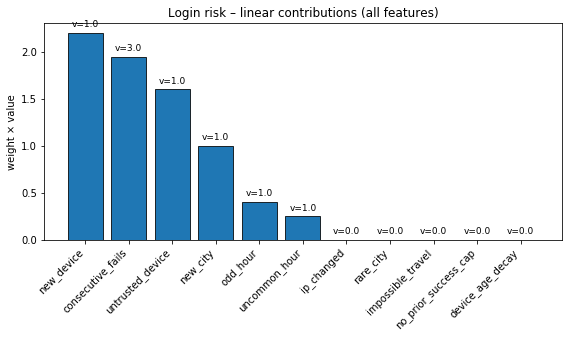

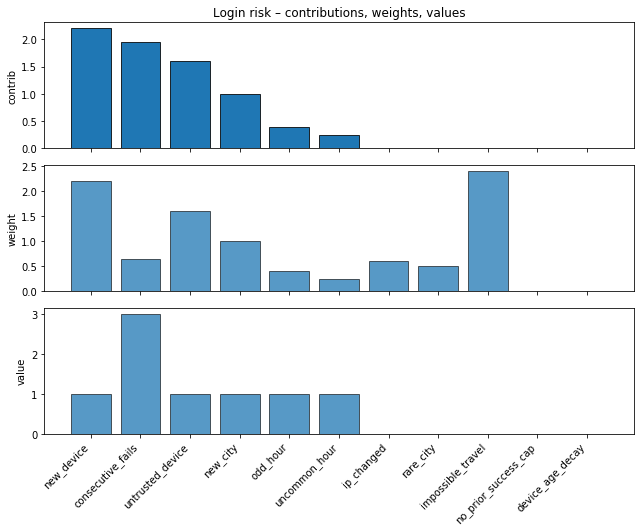

What-if echo: {'using_private_ip': False, 'ip': '1.1.1.1', 'set_hour': 3, 'force_new_device': True, 'force_known_device': None, 'consecutive_fails': 0, 'travel_from_ip': '8.8.8.8', 'travel_hours_ago': 3.0, 'clear_hours_hist': True, 'clear_city_hist': False, 'clear_device_trust': False, 'treat_city_as_new': True, 'treat_city_as_rare': False, 'override_features': {'odd_hour': 1.0, 'uncommon_hour': 1.0, 'consecutive_fails': 3.0, 'impossible_travel': 0.0}, 'geo_provider': 'IPINFO', 'ip_city': 'Brisbane, AU', 'geo_ok': True, 'geo_latlon': [-27.4816, 153.0175], 'speed_kmh': 228118.5, 'prev_ip': '1.1.1.1', 'ip_changed': False}
Bias term: -1.5
Sum(contrib) = 7.4
Total logit ≈ 5.9

Top contributions:
 - new_device           value=1.0    weight=2.20    contrib=2.20  
 - consecutive_fails    value=3.0    weight=0.65    contrib=1.95  
 - untrusted_device     value=1.0    weight=1.60    contrib=1.60  
 - new_city             value=1.0    weight=1.00    contrib=1.00  
 - odd_hour             value=1

In [35]:
# local XAI: visualize contributions for ALL features (via /xai/explain_login)
import os, math
import matplotlib.pyplot as plt

os.environ.setdefault("GEO_PROVIDER", "MAXMIND")  # or "IPINFO"
os.environ.setdefault("GEOIP_DB", "./data/GeoLite2-City.mmdb")

cfg = get_risk_cfg()
weights = cfg["weights"]
bias = float(weights.get("bias", 0.0))

xai = api(
    "POST",
    "/xai/explain_login",
    json_body={
        # Using *public* IPs so geolocation can resolve
        "ip": "1.1.1.1",                 # current login IP (Cloudflare)
        "travel_from_ip": "8.8.8.8",     # previous success IP (Google)
        "travel_hours_ago": 3.0,         # reasonable gap to avoid crazy speeds

        # Light up device/hour/history-driven features
        "force_new_device": True,        # -> untrusted_device + new_device
        "set_hour": 3,                   # early hour
        "clear_hours_hist": True,        # make it uncommon_hour
        "treat_city_as_new": True,       # allow new_city to fire if geo resolves

        # Optionally keep impossible_travel OFF so it doesn't dominate
        "override_features": {
            "odd_hour": 1.0,
            "uncommon_hour": 1.0,
            "consecutive_fails": 3.0,
            "impossible_travel": 0.0
        },

        "save_image": False
    },
)

# Build rows from returned features (includes overrides)
features = dict(xai["features_snapshot"])
rows = []
for k, w in weights.items():
    if k == "bias":
        continue
    v = features.get(k, 0.0)
    if isinstance(v, bool):
        v = 1.0 if v else 0.0
    elif not isinstance(v, (int, float)):
        v = 0.0
    rows.append({
        "feature": k,
        "value": float(v),
        "weight": float(w),
        "contrib": float(w) * float(v),
    })

# Sort by absolute impact
rows.sort(key=lambda r: abs(r["contrib"]), reverse=True)

# Arrays for plotting/printing
labels = [r["feature"] for r in rows]
values = [r["contrib"] for r in rows]
values_abs = [abs(v) for v in values]
wts  = [r["weight"] for r in rows]
vals = [r["value"]  for r in rows]

# Simple contributions plot
w_fig = max(8, min(24, 0.6 * len(rows)))
plt.figure(figsize=(w_fig, 4.8))
bars = plt.bar(range(len(values)), values, linewidth=0.8, edgecolor="black")

# De-emphasize zero-contribution bars & annotate values
for bar, r in zip(bars, rows):
    if abs(r["contrib"]) < 1e-9:
        bar.set_alpha(0.35)
        bar.set_linewidth(0.8)
for bar, r in zip(bars, rows):
    y = bar.get_height()
    offset = 0.02 if y >= 0 else -0.04
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        y + offset * (max(values_abs) + 1e-6),
        f"v={r['value']}",
        ha="center",
        va="bottom" if y >= 0 else "top",
        fontsize=9,
    )

plt.xticks(range(len(values)), labels, rotation=45, ha="right")
plt.axhline(0, linewidth=1)
plt.title("Login risk – linear contributions (all features)")
plt.ylabel("weight × value")
plt.tight_layout()
plt.show()

# Tri-panel: contributions, weights, values
width = max(9, min(26, 0.65 * len(rows)))
fig, axes = plt.subplots(3, 1, figsize=(width, 7.5), sharex=True)

axes[0].bar(range(len(values)), values, linewidth=0.8, edgecolor="black")
axes[0].axhline(0, linewidth=1); axes[0].set_ylabel("contrib")
axes[0].set_title("Login risk – contributions, weights, values")

axes[1].bar(range(len(wts)), wts, linewidth=0.8, edgecolor="black", alpha=0.75)
axes[1].axhline(0, linewidth=1); axes[1].set_ylabel("weight")

axes[2].bar(range(len(vals)), vals, linewidth=0.8, edgecolor="black", alpha=0.75)
axes[2].axhline(0, linewidth=1); axes[2].set_ylabel("value")
axes[2].set_xticks(range(len(labels))); axes[2].set_xticklabels(labels, rotation=45, ha="right")
plt.tight_layout(); plt.show()

print("What-if echo:", xai.get("what_if_echo"))
print("Bias term:", bias)
print("Sum(contrib) =", round(sum(values), 3))
print("Total logit ≈", round(bias + sum(values), 3))
print("\nTop contributions:")
for r in rows[:15]:
    print(f" - {r['feature']:<20} value={r['value']:<5}  weight={r['weight']:<6.2f}  contrib={r['contrib']:<6.2f}")

if "why_zero" in xai:
    nonzero = {r["feature"] for r in rows if abs(r["contrib"]) > 0}
    zeros = {k: v for k, v in xai["why_zero"].items() if k not in nonzero}
    if zeros:
        print("\nWhy-zero (server view):")
        for k, v in zeros.items():
            print(f" - {k:<20} reason={v['reason']:<16} weight={v['weight']:<5} value={v['value']}")


## tests/test_adversary.py

These tests validate the adversarial simulation and fuzzing endpoints end-to-end, across generation, risk scoring, geo/device intelligence, persistence, analytics, and performance.

### Core coverage

#### 1) Attack generation
**Endpoint:** `POST /adversary/generate`
**What’s checked:**
* `credential_stuffing`, `device_spoof`, `impossible_travel`, and `mixed` produce non-empty lists and respect `count`.
* Login attacks include `ip`, `ua`; tx fuzz includes `amount`, `currency`, `category`.

#### 2) Attack execution (preview)
**Endpoint:** `POST /adversary/run` with `persist=false`
**What’s checked:**
* `generated`, `inserted` (0 in preview), `step_up_rate`, `hard_deny_rate`.
* A `sample` list exists and entries include `ip`, `ua`, `pred_risk`, `raw_parts`, `raw_details`.
  **Why deterministic:** risk scoring is monkey-patched to a constant 85 to keep tests stable.

#### 3) Attack execution (persisting)
**Endpoint:** `POST /adversary/run` with `persist=true`
**What’s checked:**
* Exactly `count` `LoginEvent` rows are inserted for the current user.

#### 4) Impossible travel pairing
**Endpoint:** `POST /adversary/run` with `attack="impossible_travel"`
**What’s checked:**
* Paired events flatten correctly, `generated` matches request, and `avg_risk` falls in ~80–90 with the deterministic stub.

#### 5) Transaction fuzzing (cold start)
**Endpoint:** `POST /adversary/tx_fuzz` (no prior history)
**What’s checked:**
* Returns `count` rows with integer `score` and expected keys. Handles “not enough history to train” gracefully.

#### 6) Transaction fuzzing (with history)
**Endpoint:** `POST /adversary/tx_fuzz` after seeding transactions
**What’s checked:**
* Returns `count` rows and all `score` values are within 0–100.

#### 7) Input validation
**Endpoints:** `POST /adversary/generate`, `POST /adversary/run`
**What’s checked:**
* Invalid attack names and non-positive counts return 400/422.

#### 8) Geo “Unknown city” edge case
**Endpoint:** `POST /adversary/run`
**What’s checked:**
* When `_geo_for_ip` returns `("0.0","0.0","Unknown")`, the run still succeeds and returns valid summary fields.

#### 9) Device trust influences risk
**Endpoint:** `POST /adversary/run` (`device_spoof`)
**What’s checked:**
* A trusted device seeded in DB + a scorer patch that lowers risk for trusted devices reduces `avg_risk` relative to the 85 baseline—verifying device trust is plumbed into scoring.

#### 10) Preview runs don’t leak to analytics
**Endpoints:** `GET /logs/summary`, `POST /adversary/run` (preview)
**What’s checked:**
* If the logs router is available, preview runs do **not** change `/logs/summary` counts (no-persist = no analytics mutation).
  **Note:** This test auto-skips when the logs router isn’t mounted/available.

#### 11) AE (AutoEncoder) backend (conditional)
**Endpoint:** `POST /adversary/tx_fuzz` with `backend="ae"`
**What’s checked:**
* If AE is supported, endpoint responds with shaped rows.
  **Why it may be skipped:** The test is guarded by a skip condition if PyTorch is unavailable or the router doesn’t expose a `TORCH_AVAILABLE` flag. This is expected and safe to leave skipped.

#### 12) Large-count performance / capping
**Endpoint:** `POST /adversary/run` with a large `count`
**What’s checked:**
* Endpoint responds within a generous time bound and `generated` is within `[1, requested]`.
* If validation caps `count`, the test retries with a smaller value (e.g., 100).

### What’s mocked/stubbed
* **Risk engine:** `risk_engine.score_login` is patched to always return `(85, [...], {...})` for stability.
* **Current user:** dependency override injects a unique test user per run.
* **DB:** shared in-memory SQLite via `StaticPool` so tables persist across sessions within a run.

In [36]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))
os.environ["PYTEST_DISABLE_PLUGIN_AUTOLOAD"] = "1"
!pytest -q -p no:dash test_adversary.py

................s.                                                       [100%]
=============================== warnings summary ===============================
../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291
../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291
../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291
../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291
  /Users/ayesharahman1/opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
    warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)

../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:341
  /Users/ay

## Threat Intelligence (TI) Test Suite

These tests verify the **Threat Intelligence subsystem** (`/ti` endpoints) of the backend, ensuring it loads threat-feeds, returns expected indicators, and respects enable/disable flags.
All requests are automatically authenticated via a dependency override in the tests (no real login required).

### What the tests do

#### 1. Feed Initialization & Status
**Endpoint:** `GET /ti/status`
**Test:** `test_status_counts`
* Creates temporary local text feeds for bad IPs, TOR exits, ASNs, and disposable email domains.
* Reloads `threat_intel` to ingest them.
* Verifies the counts and the “enabled” flag in `/ti/status`.
* Expected counts:
  * `bad_ip` = 2
  * `tor` = 1
  * `bad_asn` = 1
  * `bad_domains` = 2

#### 2. Bad-IP Detection
**Endpoint:** `GET /ti/lookup_ip?ip=1.1.1.1`
**Test:** `test_lookup_bad_ip`
* Confirms the lookup marks `ti_bad_ip=True` and `ti_tor_exit=False`.
* Demonstrates CIDR/IP reputation lookup logic.

#### 3. TOR Exit Detection
**Endpoint:** `GET /ti/lookup_ip?ip=2.2.2.2`
**Test:** `test_lookup_tor_ip`
* Confirms TOR IPs return `ti_tor_exit=True` and are not flagged as `ti_bad_ip`.
* Validates multiple feed sources can coexist correctly.

#### 4. Disposable Email Domain Detection
**Endpoint:** `GET /ti/check_email_domain?email=alice@mailinator.com`
**Test:** `test_check_email_domain_disposable`
* Checks that the email’s domain is extracted and flagged via `ti_disposable_email=True`.
* Ensures privacy-aware domain-only checking (no full email logging).

#### 5. Disabled TI Mode
**Endpoint:** `GET /ti/status` after setting `TI_ENABLE=0`
**Test:** `test_ti_disabled`
* Temporarily disables threat-intel via environment variable.
* Reloads the module and confirms all counts reset to 0 and `enabled=False`.

In [37]:
import subprocess, shlex
cmd = "pytest -q test_ti.py -W ignore::DeprecationWarning -W ignore::UserWarning"
completed = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
print(completed.stdout)
print(completed.stderr)
if completed.returncode != 0:
    raise SystemExit(completed.returncode)


.....                                                                    [100%]
5 passed in 5.50s




## Production level volume demonstration

In [38]:
import asyncio, httpx, random, time

BASE = "http://127.0.0.1:8000"
EMAIL = "ti-hammer@example.com"
PASSWORD = "SuperSecret123!"
IPS = ["1.1.1.1", "2.2.2.2", "8.8.8.8", "203.0.113.5", "192.0.2.10", "2001:4860:4860::8888"]

# --- knobs ---
TOTAL_REQUESTS = 50_000
CONCURRENCY    = 200        # total concurrent tasks
MAX_CONN       = 600        # httpx max total connections
MAX_KEEPALIVE  = 400        # keep-alive pool
TIMEOUT        = 15.0       # total per-request timeout (s)
CONNECT_TMO    = 10.0       # connect timeout
RETRIES        = 2          # lightweight client-side retries

async def login(ac: httpx.AsyncClient):
    # best effort register (ignore errors if already exists)
    try:
        await ac.post("/auth/register", json={"email": EMAIL, "password": PASSWORD})
    except Exception:
        pass
    r = await ac.post("/auth/login", json={
        "email": EMAIL,
        "password": PASSWORD,
        "device": {"device_id": "nb", "os": "darwin", "model": "nb", "locale": "en-US"}
    })
    r.raise_for_status()
    token = r.json()["access_token"]
    return {"Authorization": f"Bearer {token}"}

async def one_request(ac: httpx.AsyncClient, headers):
    choice = random.random()
    try:
        if choice < 0.2:
            r = await ac.get("/ti/status", headers=headers)
        elif choice < 0.8:
            ip = random.choice(IPS)
            r = await ac.get("/ti/lookup_ip", params={"ip": ip}, headers=headers)
        else:
            email = f"user{random.randint(1,1_000_000)}@mailinator.com"
            r = await ac.get("/ti/check_email_domain", params={"email": email}, headers=headers)
        return r.status_code == 200
    except httpx.PoolTimeout:
        # brief backoff to ease pool pressure
        await asyncio.sleep(0.01)
        return False
    except Exception:
        return False

async def worker(ac: httpx.AsyncClient, headers, n):
    ok = 0
    for _ in range(n):
        # simple retry loop
        for attempt in range(RETRIES + 1):
            good = await one_request(ac, headers)
            if good:
                ok += 1
                break
            # tiny jitter backoff if failed
            await asyncio.sleep(0.005 * (attempt + 1))
    return ok

async def main(total_requests=TOTAL_REQUESTS, concurrency=CONCURRENCY):
    limits = httpx.Limits(
        max_connections=MAX_CONN,
        max_keepalive_connections=MAX_KEEPALIVE,
        keepalive_expiry=30.0,
    )
    timeout = httpx.Timeout(TIMEOUT, connect=CONNECT_TMO)
    async with httpx.AsyncClient(
        base_url=BASE,
        limits=limits,
        timeout=timeout,
        trust_env=False,      # ignore proxy env vars
        headers={"Connection": "keep-alive"},
        transport=httpx.AsyncHTTPTransport(retries=RETRIES),
    ) as ac:
        headers = await login(ac)
        await ac.post("/ti/reload", headers=headers)

        per = total_requests // concurrency
        t0 = time.time()
        oks = await asyncio.gather(*[worker(ac, headers, per) for _ in range(concurrency)])
        dt = time.time() - t0
        sent = per * concurrency
        print(f"sent: {sent}, ok: {sum(oks)}, time: {dt:.2f}s, rps: {int(sent/dt)}")

await main()

sent: 50000, ok: 50000, time: 1551.07s, rps: 32


## SOC tools testing

In [39]:
from fastapi import APIRouter, Depends, Query
from typing import List, Dict, Any
from app.deps import current_user
from app import models, threat_intel as ti

router = APIRouter(prefix="/soc", tags=["soc"])

# In-memory simulated alert store
ALERTS: List[Dict[str, Any]] = []

@router.post("/alert")
def create_alert(event: Dict[str, Any]):
    """Ingest a new alert from risk model output"""
    ALERTS.append(event)
    return {"status": "ok", "count": len(ALERTS)}

@router.get("/alerts")
def list_alerts(limit: int = Query(50)):
    """Fetch latest alerts for dashboard display"""
    return ALERTS[-limit:]

@router.get("/recheck_ip")
def recheck_ip(ip: str):
    """SOC analyst can manually requery TI"""
    return ti.lookup_ip(ip)

In [40]:
import time, random, requests

BASE = "http://127.0.0.1:8000"

events = []
now = int(time.time())
ips = ["1.1.1.1","2.2.2.2","8.8.8.8","203.0.113.5","192.0.2.10","2001:4860:4860::8888"]
users = ["alice","bob","carol","dave"]
evts  = ["login_failed","login_succeeded","step_up_required","hard_deny"]

for i in range(200):  # make 200 alerts over the last few hours
    events.append({
        "timestamp": now - random.randint(0, 4*3600),   # last 4h
        "ip": random.choice(ips),
        "user": random.choice(users),
        "event": random.choice(evts),
        "score": random.randint(0, 100),
    })

ok = 0
for e in events:
    r = requests.post(f"{BASE}/soc/alert", json=e, timeout=10)
    if r.status_code == 200:
        ok += 1

print(f"seeded {ok}/{len(events)} alerts")
print(requests.get(f"{BASE}/soc/alerts", timeout=10).json()[:2])  # peek


seeded 200/200 alerts
[{'timestamp': 1760097025, 'ip': '192.0.2.10', 'user': 'carol', 'event': 'login_succeeded', 'score': 50, 'id': '2272e9eaaf804e348e4de23e80210f4e'}, {'timestamp': 1760097022, 'ip': '2.2.2.2', 'user': 'dave', 'event': 'login_succeeded', 'score': 3, 'id': '5905c62e488e4affa5f81f1196387372'}]


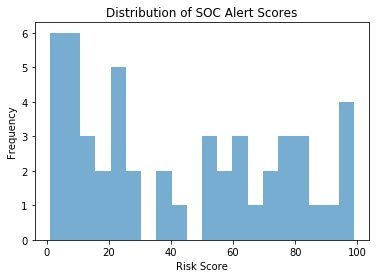

In [41]:
import pandas as pd
import requests, matplotlib.pyplot as plt

BASE = "http://127.0.0.1:8000"
data = requests.get(f"{BASE}/soc/alerts").json()

if not data:
    print("No alerts yet. Generate some with POST /soc/alert and rerun this cell.")
else:
    df = pd.json_normalize(data)
    ts_col = next((c for c in ["timestamp","ts","time","ts_epoch","ts_ms","ts_iso"] if c in df.columns), None)
    df["time"] = pd.to_datetime(df[ts_col], unit="s", errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    df["score"].plot(kind="hist", bins=20, alpha=0.6)
    plt.title("Distribution of SOC Alert Scores")
    plt.xlabel("Risk Score")
    plt.show()

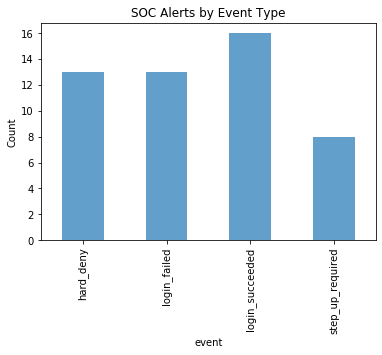

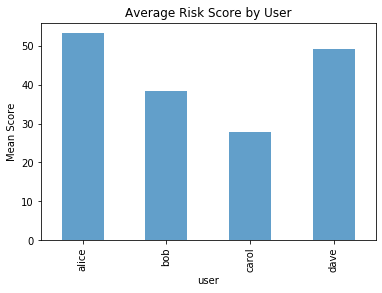

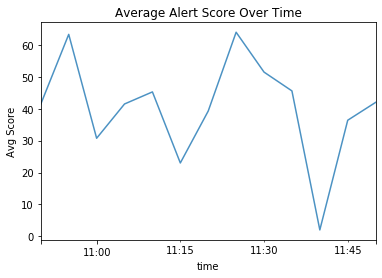

In [42]:
# Count by event type
df.groupby("event").size().plot(kind="bar", alpha=0.7)
plt.title("SOC Alerts by Event Type")
plt.ylabel("Count")
plt.show()

# Average score by user
df.groupby("user")["score"].mean().plot(kind="bar", alpha=0.7)
plt.title("Average Risk Score by User")
plt.ylabel("Mean Score")
plt.show()

# Alerts over time (timeline)
df["score"].resample("5min").mean().plot(alpha=0.8)
plt.title("Average Alert Score Over Time")
plt.ylabel("Avg Score")
plt.show()

In [43]:
!pytest -q test_soc.py

.                                                                        [100%]
=============================== warnings summary ===============================
../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291
../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291
../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291
../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291
  /Users/ayesharahman1/opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:291: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
    warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)

../../../../opt/anaconda3/lib/python3.8/site-packages/pydantic/_internal/_config.py:341
  /Users/ay

## 14) Account deletion

In [44]:
section("Account deletion – throwaway user")
import requests, time, pathlib

BASE = "http://127.0.0.1:8000"
ART = pathlib.Path("./artifacts")
ART.mkdir(exist_ok=True)
tiny_png = bytes.fromhex(
    "89504E470D0A1A0A0000000D4948445200000001000000010802000000907724"
    "0000000A49444154789C6360000002000100FFFF03000006000557BF1A00000000"
    "49454E44AE426082"
)

s2 = requests.Session()
HEADERS2 = {"Content-Type": "application/json"}

def api2(method, path, *, json_body=None, params=None, ok=(200,)):
    url = f"{BASE}{path}"
    r = s2.request(method, url, json=json_body, params=params, headers=HEADERS2, timeout=60)
    if r.status_code not in ok:
        raise RuntimeError(f"{method} {path} -> {r.status_code} {r.text}")
    if r.headers.get("content-type","").startswith("application/json"):
        return r.json()
    return r.text

tmp_email = f"delme+{int(time.time())}@example.com"
api2("POST", "/auth/register", json_body={"email": tmp_email, "password": "tmp123"})
tok = api2("POST", "/auth/login", json_body={"email": tmp_email, "password": "tmp123", "device": {}})
s2.headers["Authorization"] = f"Bearer {tok['access_token']}"

# upload tiny avatar
png_path2 = ART / "avatar_del.png"
with open(png_path2, "wb") as f:
    f.write(tiny_png)
r = s2.post(f"{BASE}/me/avatar", files={"file": ("a.png", open(png_path2,"rb"), "image/png")}, timeout=60)
print("tmp avatar upload:", r.status_code)

# delete account
dele = s2.delete(f"{BASE}/me", timeout=60)
print("delete status:", dele.status_code)

# confirm token can no longer read /me
r2 = s2.get(f"{BASE}/me", timeout=60)
print("me after delete (expect 401):", r2.status_code)


Account deletion – throwaway user
tmp avatar upload: 200
delete status: 204
me after delete (expect 401): 401
